# K-Means Clustering in R 

## Generate Data and Import Libraries

Import all libraries with the code below, all libraries used in this tutorial come pre-installed with Watson Studio.

If you wish to customize the code and you need to install a library that does not come pre-installed, run `install.packages('library_name')` in a code cell to install that library into the environment before importing it with the `library()` function.

In [1]:
library(ggplot2)
library(MASS)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()



To generate our data set, we will use the `mvrnorm` function from the `MASS` package. This is a useful function to create test data sets for machine learning algorithms, including clustering and classification algorithms.

The function will create clusters of data with a Gaussian distribution that can be used for evaluating the performance of our clustering algorithm. `set.seed()` is used for reproducability, as there is some degree of randomness in the way the function generates the data sets. `num_features` parameter refers to how many dimensions each different data point will have. Those of you without a Machine Learning and Statistics background can think of this as the number of variables collected or columns each observation in the data set has.

In [2]:
n_samples <- 5000
n_features <- 5
centers <- 5
cluster_std <- 0.1

# Create an empty matrix to store the data
X <- matrix(0, n_samples, n_features)

# Define random cluster centers
set.seed(42)
random_centers <- matrix(runif(centers * n_features, -10, 10), nrow=centers)

# Populate the matrix with blobs
for (i in 1:centers) {
  # Calculate start and end indices for this blob
  start_idx <- (i-1) * (n_samples / centers) + 1
  end_idx <- i * (n_samples / centers)
  
  # Generate multivariate normal data for this blob
  X[start_idx:end_idx, ] <- mvrnorm(n_samples / centers, random_centers[i,], diag(cluster_std, n_features))
}

# Generate the labels
y <- rep(1:centers, each=n_samples/centers)

feature_names <- paste0("feature_", 0:(n_features-1))
df <- as.data.frame(X)
colnames(df) <- feature_names

# Add the labels
df$label <- y

cat(paste("Dimensions of Dataframe: ", paste(dim(df), collapse = " x ")), "\n")

Dimensions of Dataframe:  5000 x 6 


Lets examine the first five rows of the data with the `head()` function. Note that in this instance, we generated a label column. This library is designed to help Data Scientists test their models, so a labeled data set can be useful for validating the effecitveness of your algorithm by comparing the predicted labels to real labels after clustering. However, it should be noted that unsupervised algorithms like K-means are often used when data is not already labeled or grouped into a categrory, and that other data sets will likely not come pre-labelled.  

In [3]:
head(df, 5)

,feature_0,feature_1,feature_2,feature_3,feature_4,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,8.050328,0.47522164,-1.4452228,8.953739,8.091895,1
2,8.546218,0.27916869,-0.6482263,8.736405,8.496454,1
3,7.946847,0.39241694,-0.8860805,9.127797,8.389951,1
4,8.393435,0.55909488,-0.4217839,8.619598,8.359475,1
5,8.671820,-0.01960991,-0.4085478,8.558167,8.233114,1


To give the user a real life example of K-means clustering, we will pretend that these mock data correspond to a scenario where a real estate company wants to group similar properties together to help potential buyers find homes that fit their preferences. The columns will be property size, number of rooms, distance to city center, property age and utility costs. 

Let's rename the column names to correspond to our scenario:

In [4]:
colnames(df) <- c('property_size', 'num_rooms', 'distance_center', 'age', 'utility_cost', 'label')

head(df, 5)

,property_size,num_rooms,distance_center,age,utility_cost,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,8.050328,0.47522164,-1.4452228,8.953739,8.091895,1
2,8.546218,0.27916869,-0.6482263,8.736405,8.496454,1
3,7.946847,0.39241694,-0.8860805,9.127797,8.389951,1
4,8.393435,0.55909488,-0.4217839,8.619598,8.359475,1
5,8.671820,-0.01960991,-0.4085478,8.558167,8.233114,1


## Exploratory analysis and visualizations

First, lets visualize the different blobs. We will plot the first two features against each other. Since this data has 5 and not 2 dimensions, it is not a complete representation of the data, but it is helpful to visualize the 5 distinct groups of data, which we will later train a model to identify itself with the K-means algorithm. Clusters 1, 2, and 4 are pretty separated, while the boundary between clusters 0 and 5 is overlapping. When clusters are close like this, it may make it harder to for the algorithm to accurately distinguish between clusters.

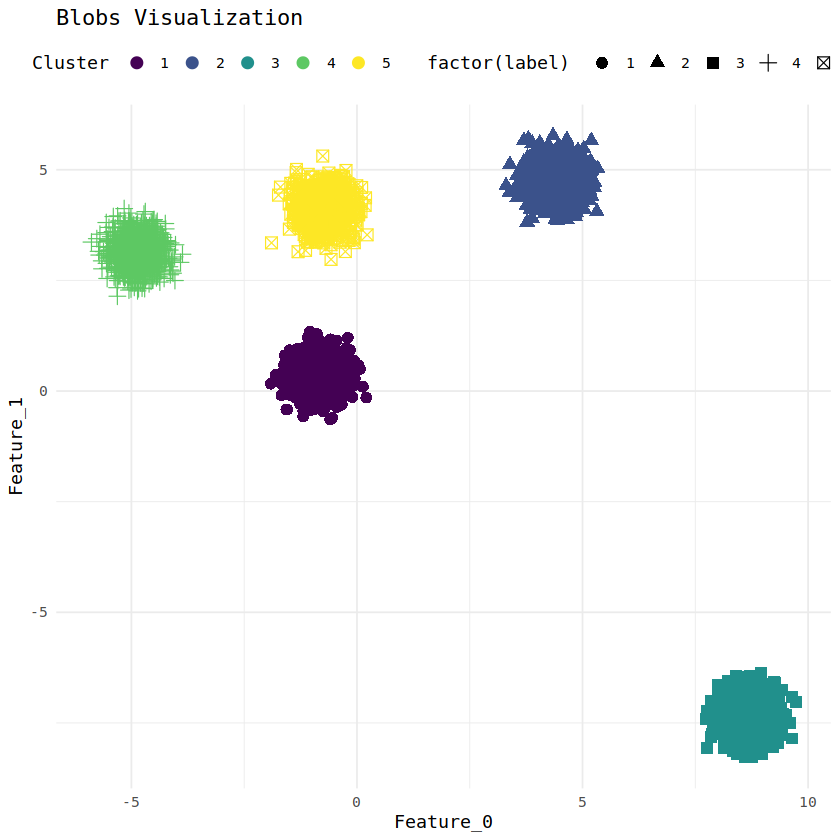

In [5]:
# Plot the data
p <- ggplot(df, aes(x=distance_center, y=num_rooms, color=factor(label))) + 
  geom_point(aes(shape=factor(label)), size=3) + 
  scale_color_viridis_d(name="Cluster") +
  labs(title="Blobs Visualization", x="Feature_0", y="Feature_1") +
  theme_minimal() +
  theme(legend.position="top")

p

Next, let's check if the columns were imported as the correct data type and check our data set for missing values.

This verifies that there are also no categorical data columns. K-means clustering can only be applied to continuous data. Categorical data would need to either be removed or recoded numerically if appropriate before proceeding.

In [130]:
str(df)

'data.frame':	5000 obs. of  6 variables:
 $ property_size  : num  8.05 8.55 7.95 8.39 8.67 ...
 $ num_rooms      : num  0.4752 0.2792 0.3924 0.5591 -0.0196 ...
 $ distance_center: num  -1.445 -0.648 -0.886 -0.422 -0.409 ...
 $ age            : num  8.95 8.74 9.13 8.62 8.56 ...
 $ utility_cost   : num  8.09 8.5 8.39 8.36 8.23 ...
 $ label          : int  1 1 1 1 1 1 1 1 1 1 ...


In [131]:
colSums(is.na(df))

property_size       num_rooms distance_center             age    utility_cost 
              0               0               0               0               0 
          label 
              0

There are no missing values, and each data type is correct. Now let's visualize the distribution of each column. This can help us better understand the shape of our data, and if scales may need to be standaridized later.

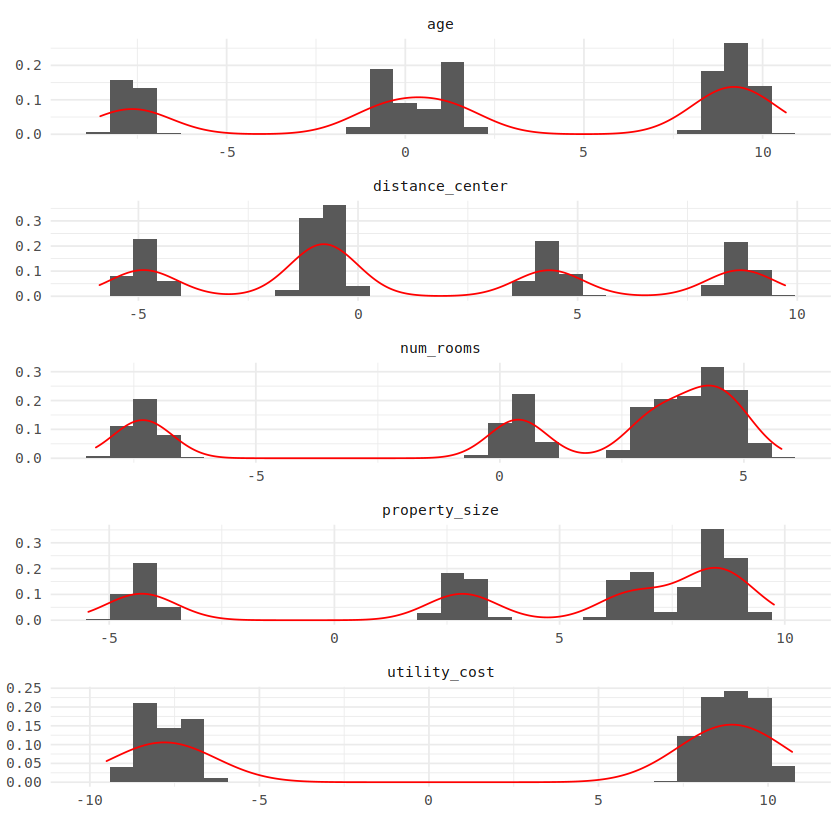

In [132]:
#use these indexes to remove label col
df_long <- df[1:5] %>% 
  gather(key = "column_name", value = "value")

p <- ggplot(df_long, aes(x=value)) +
  geom_histogram(aes(y=..density..), bins=30) +   # histogram
  geom_density(alpha=.2, color="red") +       # Kernel Density Estimate
  facet_wrap(~ column_name, scales = "free", ncol = 1) +
  labs(y="", x="") +
  theme_minimal() +
  theme(axis.title.y=element_blank())

print(p)

## Outlier Identification

Outliers do not fit neatly into any cluster, and can confuse the algorithm when drawing cluster boundaries. It is not always appropriate to remove outliers, but for now we will check for them and remove them before proceeding. There are multiple ways to check for outliers, including clustering algorithms like DBSCAN. For now, we will remove all outliers that have a Z score greater than a threshold value of 2.5. This means that we will remove any value that is more than 2.5 standard deviations away from the column mean:

In [133]:
# Calculate z-scores
z_scores <- scale(df)

# Filter rows where all absolute z-scores are greater than 2.5
outlier_rows <- apply(abs(z_scores) > 2.5, 1, all)

# Print rows considered as outliers
print(df[outlier_rows, ])

[1] property_size   num_rooms       distance_center age            
[5] utility_cost    label          
<0 rows> (or 0-length row.names)


This data set has seems to have no outliers. We do not need to consider removing any data.

## Scale Standardization

We will ignore the labels column for now, since this column identifies which cluster each observation belongs too and is not a real variable. As we can see above, each variable follows a mixed Gaussian distribution and has between two and three peaks. Since K-means is a distance based algorithm, it is important that each variable follows the same scale. This means that observations are represented as n-dimensional vectors in a high feature space, and distances between the points are calculated mathematically. If one feature uses a different scale, it can drastically affect the distance score and produce undesirable results.

As we can see in the above histograms, our features have different ranges. It is best practice to standardize scales between features. Two common techniques are standarization and normalization. Normalization can be appropriate for certain algorithms where the data is assumed to have a normal distribution. Standardization does not change the underlying distribution of the data, and since K-means does not require that features be normalized, we will standardize our data.

Perform standardization with R's `scale()` function:

In [134]:
# Save original df for later
df_original <- df

# Standardize df
df <- as.data.frame(scale(df))

Notice how the scales are now uniform across features when visualizing the data's distribution:

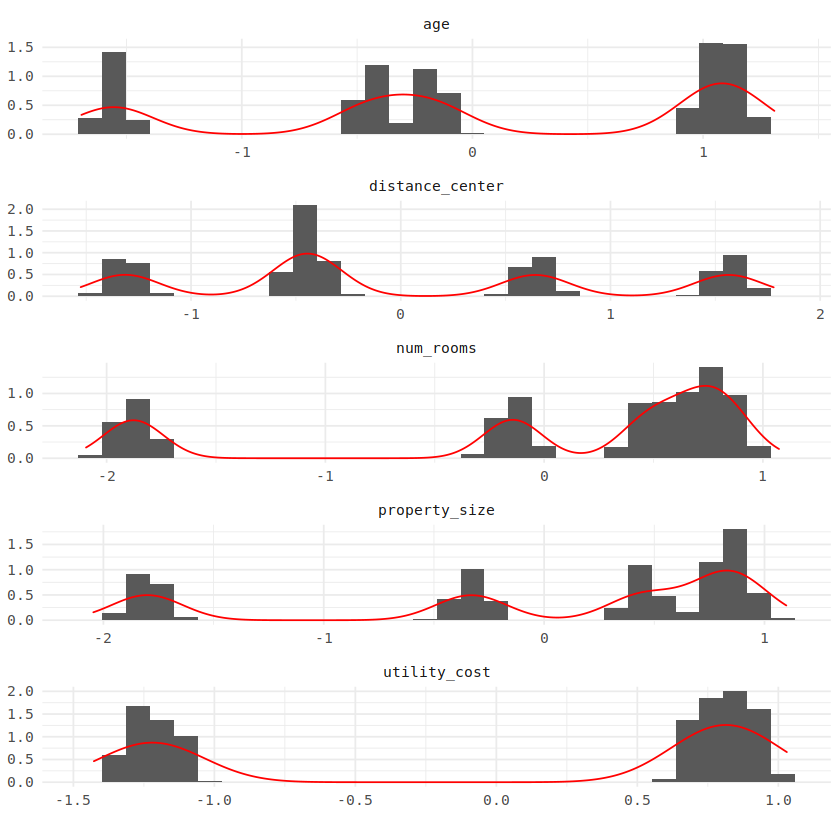

In [135]:
#use these indexes to remove label col
df_long <- df[1:5] %>% 
  gather(key = "column_name", value = "value")

p <- ggplot(df_long, aes(x=value)) +
  geom_histogram(aes(y=..density..), bins=30) +   # histogram
  geom_density(alpha=.2, color = 'red') +       
  facet_wrap(~ column_name, scales = "free", ncol = 1) +
  labs(y="", x="") +
  theme_minimal() +
  theme(axis.title.y=element_blank())

print(p)

## Correlation Analysis

Before clustering our data, we need to check that our features are not correlated. This is important because correlation means that two features might carry the same information, and influence the algorithm unintentionally when calculating distance.

If we identify correlated features before clustering, we can choose to drop one, or to modify the features in some way:

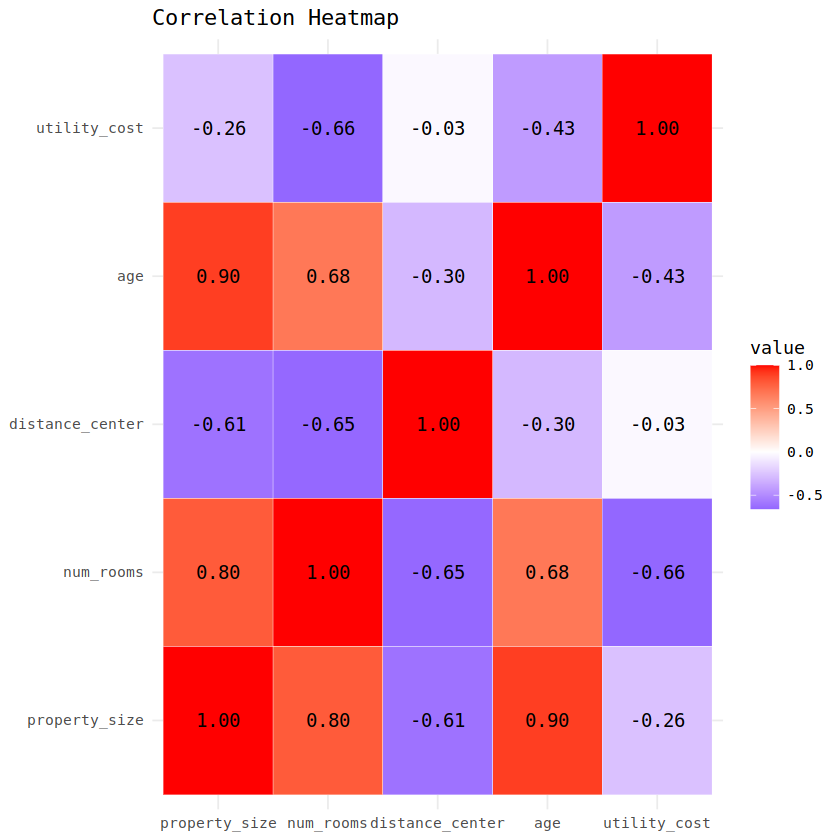

In [136]:
# Exclude the label column
df_features <- df[, -which(names(df) == "label")]

# Reshape the data for ggplot
cor_df <- as.data.frame(as.table(cor(df_features)))
names(cor_df) <- c("Var1", "Var2", "value")

# Create the heatmap
library(ggplot2)
ggplot(data=cor_df, aes(Var2, Var1)) +
  geom_tile(aes(fill=value), color="white") +
  scale_fill_gradient2(low="blue", high="red", mid="white", midpoint=0) +
  geom_text(aes(label=sprintf("%.2f", value)), size=4) +
  theme_minimal() +
  theme(axis.title.x=element_blank(),
        axis.title.y=element_blank()) +
  labs(title="Correlation Heatmap")

The above heatmap is a visualization of the correlation matrix of our data's features. The metric displayed is Pearson's Correlation Coefficient. If two features have a correlation close to 1 or -1, it means that there is a strong positive or negative correlation between them respectively.

Notice the that number of rooms is highly correlated to the property size (correlation=0.80). If certain features are highly correlated, the cluster shape might be unintentionally stretched in one direction by two features that largely carry the same information. It is not a hard rule that correlated features must be removed, but in general it is advisable and you can remove one of the two columns from the dataframe with the code below:

In [139]:
df <- select(df, -property_size)

colnames(df)

[1] "num_rooms"       "distance_center" "age"             "utility_cost"   
[5] "label"

## Elbow Method to Estimate K

K refers to the number of clusters that the algorithm should generate.

We know that we should have 5 different clusters, since our data has 5 different centers. However, unsupervised learning techniques are used to learn relationships between features automatically. When the meaning of features is not clear, it might not be obvious how many clusters should be generated. If you have a specific use case where you need to classify into a specific number of groups, you might also choose to specify the number of clusters yourself.

The Elbow method identifies the optimal number of clusters by running the algorithm for a range of k values and then computing the sum of squared distances of the data point to the center of the cluster. This is then plotted against the number of clusters.

Eventually, the within cluster sum of squares will stop marginally decreasing, meaning that an increase in the number of clusters does not improve the performance of the algorithm, and only increases computational cost. This "elbow" point in the graph can be used to identify the optimal number of clusters, which in this case is 5 as we expected.


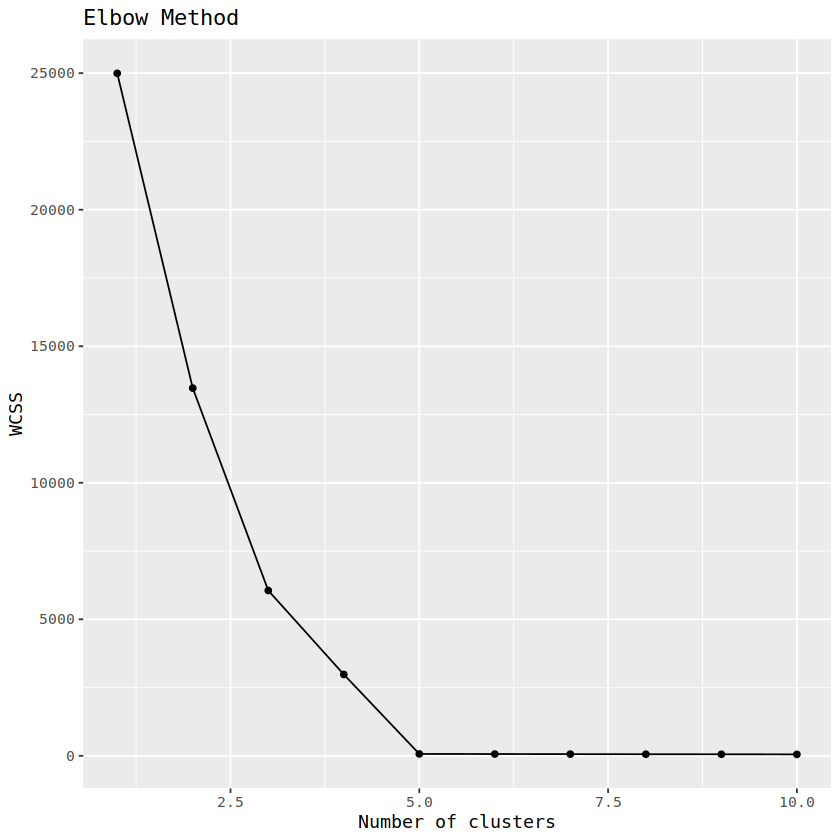

In [141]:
# Define the max number of clusters to test
max_clusters <- 10

# Initialize a vector to store the WCSS values
wcss <- numeric(max_clusters)

# Loop over several values of k (number of clusters)
for (k in 1:max_clusters) {
  set.seed(42)  # Set seed for reproducibility
  kmeans_model <- kmeans(df, centers=k, iter.max=300, nstart=10)
  wcss[k] <- kmeans_model$tot.withinss
}

# Plot the results
ggplot(data.frame(k = 1:max_clusters, wcss = wcss), aes(x = k, y = wcss)) +
  geom_line() +
  geom_point() +
  ggtitle("Elbow Method") +
  xlab("Number of clusters") +
  ylab("WCSS")


## Clustering and Visualizing Clusters

In [144]:
set.seed(42)  # Set seed for reproducibility
kmeans_model <- kmeans(df, centers=5, nstart=10)
df$predicted_labels <- as.factor(kmeans_model$cluster)

Keep in mind that we are using 5 dimensional data. We cannot simply graph the clusters in a 2-D space. Thus, we will use PCA to reduce the dimensionality of the data to two features. Explaining PCA and the meaning of principal components is beyond the scope of this article, but for now just understand that it attempts to preserve the information in the data while reducing dimensionality.

In [148]:
pca_model <- prcomp(df[1:5], center = TRUE, scale. = TRUE)
reduced_data <- pca_model$x[, 1:2]  # Taking the first two principal components

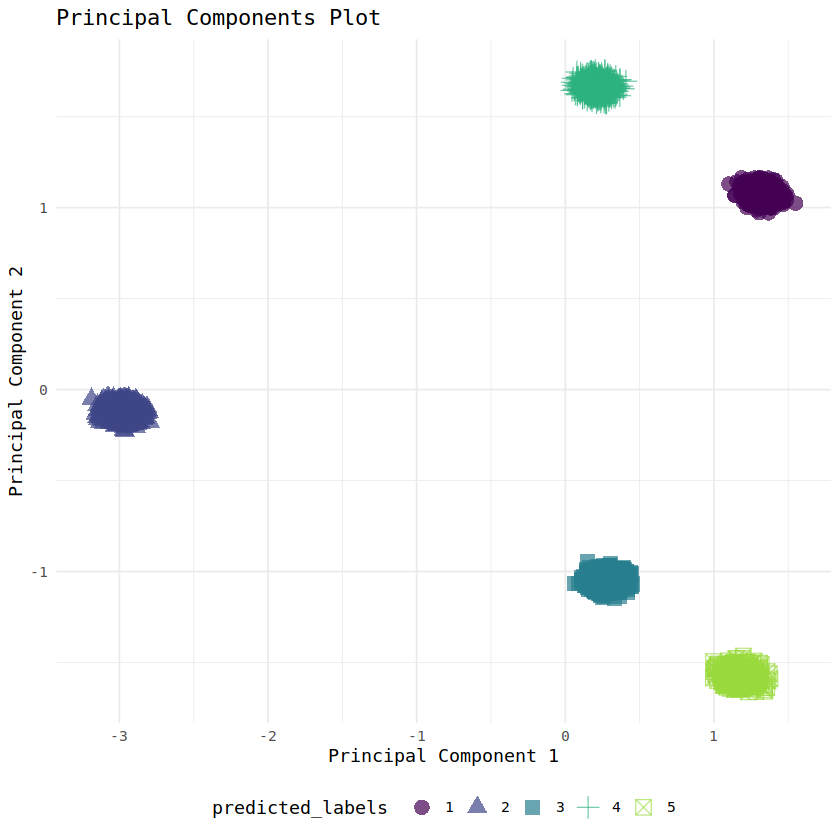

In [150]:
# Convert reduced data and predicted labels to a dataframe
pca_df <- data.frame(PC1 = reduced_data[, 1], PC2 = reduced_data[, 2], predicted_labels = df$predicted_labels)

# Plotting
library(ggplot2)
ggplot(pca_df, aes(x = PC1, y = PC2, color = predicted_labels)) +
  geom_point(size = 4, alpha = 0.7, aes(shape = predicted_labels)) +
  scale_color_viridis_d(option = "viridis", end = 0.85) +
  theme_minimal() +
  labs(title = "Principal Components Plot",
       x = "Principal Component 1",
       y = "Principal Component 2") +
  theme(legend.position = "bottom")

## Interpretation

We can observe 5 clusters from our PCA plot, which makes sense as we set k=5. Notice that certain clusters fall closer together. This implies that there is a higher degree of similarity between these clusters compared other ones which are located further away.

We have now completed our clustering, the real estate company now has a data set that classifies each property into 1 of 5 similar groups.

Thank you for following this IBM Developer tutorial.